The simple speeded up RBC with update will be discussed here. 

In [2]:
import quantecon as qe
import numpy as np 
from numba import jit , njit, prange, vectorize, jitclass, prange, float64, int32
from interpolation import mlinterp, interp
import matplotlib.pyplot as plt

from matplotlib import cm
import scipy.optimize as op

from scipy.stats import cumfreq, beta
from scipy.interpolate import interp1d
from quantecon.optimize.scalar_maximization import brent_max
from scipy.optimize import minimize_scalar

%matplotlib inline

Below is the straightforward way to compute the values of the exogenous shocks & updated parameters (make it nore efficient in the future) 

In [3]:
#This block will compute the actual realizations of states
#& updating of the beliefs by the agent 
# overall idea is on each iteration - change the distribution from wich the shocks are drawn - (Beta distribution) 
np.random.seed(1234)
n = 100 # Number of periods  
P = [[0.4,0.6],
    [0.2, 0.8]] # Transition matrix
mc = qe.MarkovChain(P,state_values = ('h','l'))
X = mc.simulate(ts_length = n) # realization of real shock


# initial values
u01= 10
u00= 10
u11= 10
u10= 5      

#Count the occurences of h and l at each time period
iks = ''.join(X)

#iks.count('hh', sub[ , 0,[,7]])
def frequencyCount(mainStr, subStr):
   counter = pos = 0
   while(True):
       pos = mainStr.find(subStr , pos)
       if pos > -1:
           counter = counter + 1
           pos = pos + 1
       else:
           break
   return counter

# mij- are the added numbers of occurrences each period  
m00 = np.empty(n, dtype = int)
m01 = np.empty(n, dtype = int)
m10 = np.empty(n, dtype = int)
m11 = np.empty(n, dtype = int)


def  createMvectors(m, subStr):
    for i in range(n):
        m[i] = frequencyCount(iks[0:i],subStr)
    return m
    
    
createMvectors(m00,'ll')
createMvectors(m01,'lh')
createMvectors(m11,'hh')
createMvectors(m10,'hl')    


#add the prior
# so that get the poserior values of beta distribution 
nu00 = m00 + u00
nu01 = m01 + u01
nu11 = m11 + u11
nu10 = m10 + u10

In [4]:
 opt_growth_data = [
    ('α', float64), # Production parameter
    ('b', float64), # Discount factor
    #('γ', float64), # Preference parameter
    ('nuii', float64), #parameter of posterior 1
    ('nuij', float64), #parameter of posterior 2
    #('s', float64), # Shock scale parameter
    ('grid', float64[:]), # Grid (array)
    ('shocks', float64[:]) # Shock draws (array)
]

In [47]:
i= 1
n=100

In [5]:
@jitclass(opt_growth_data)
class OptimalGrowthModel:
    def __init__ (self,
                  nuii  , # nu are values for beta function posterior 
                  nuij, 
                  α = 0.4,
                  b = 0.96,
                  grid_max=n,
                  grid_size=n,
                  shock_size=2*n,
                  seed=1234):
        
            self.α, self.b, self.nuii, self.nuij = α, b, nuii, nuij
                # Set up grid
            self.grid = np.linspace(1e-5, grid_max, grid_size)
                # Store shocks (with a seed, so results are reproducible)
            np.random.seed(seed)
            
            self.shocks = np.exp( np.random.beta(nuii,nuij,shock_size))    
            
    def f(self,k):
        return k**self.α
            
    def u(self, c):
        return np.log(c)
            
    def objective(self, c, y, v_array):
        """
         Right hand side of the Bellman equation.
        """
        u, f, b, shocks = self.u, self.f, self.b, self.shocks
        v = lambda x: interp(self.grid, v_array, x)
        return u(c) + b * np.mean(v(f(y - c) * shocks))
        
        
            

In [49]:
np.exp(beta(nu00[i],nu01[i]).rvs(1))

array([1.71348293])

In [6]:
@jit(nopython=True)
def T(og, v):
    """
    The Bellman operator.
    * og is an instance of OptimalGrowthModel
    * v is an array representing a guess of the value function
    """
    v_new = np.empty_like(v)
    
    for i in range(len(og.grid)):
        y = og.grid[i]
        # Maximize RHS of Bellman equation at state y
        v_max = brent_max(og.objective, 1e-10, y, args=(y, v))[1]
        v_new[i] = v_max
    
    return v_new



In [7]:
@jit(nopython=True)
def get_greedy(og, v):
    """
    Compute a v-greedy policy.
    * og is an instance of OptimalGrowthModel
    * v is an array representing a guess of the value function
    """
    v_greedy = np.empty_like(v)
    for i in range(len(og.grid)):
        y = og.grid[i]
    # Find maximizer of RHS of Bellman equation at state y
        c_star = brent_max(og.objective, 1e-10, y, args=(y, v))[0]
        v_greedy[i] = c_star
    return v_greedy


In [8]:
@jit(nopython=True)    # unseccesfuul attempt to use jit - it works longer (20 Vs 16)
def solve_modelj(og,
                tol=1e-4,
                max_iter=1000,
                print_skip=25):
    # Set up loop
    v = np.log(og.grid) # Initial condition
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        v_new = T(og, v)
        error = np.max(np.abs(v - v_new))
        i += 1
        #if verbose and i % print_skip == 0:
            #print(f"Error at iteration {i} is {error}.")
        v = v_new
    
    #if i == max_iter:
       # print("Failed to converge!")
    
    #if verbose and i < max_iter:
        #print(f"\nConverged in {i} iterations.")
    return v_new

In [9]:

def solve_model(og,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):
    # Set up loop
    v = np.log(og.grid) # Initial condition
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        v_new = T(og, v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new
    
    if i == max_iter:
        print("Failed to converge!")
    
    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")
    return v_new

In [11]:
og = OptimalGrowthModel(nuii = nu00[1], nuij =nu01[1])


In [12]:
#%%time
v_solution = solve_model(og)

Error at iteration 25 is 3.2661332725905083.
Error at iteration 50 is 0.8596141616732211.
Error at iteration 75 is 0.2286283134759799.
Error at iteration 100 is 0.06163088001105166.
Error at iteration 125 is 0.01689915546964471.
Error at iteration 150 is 0.004731365770197726.
Error at iteration 175 is 0.0013575004389281276.
Error at iteration 200 is 0.00040029571999866675.
Error at iteration 225 is 0.00012150921764941813.

Converged in 230 iterations.


In [ ]:
#%%time  # unseccessful aatempt to use jit
v_solutionj = solve_modelj(og)

In [14]:
# the resultant policy function  
v_greedy = get_greedy(og, v_solution)
fig, ax = plt.subplots()
ax.plot(og.grid, v_greedy, lw=2,
alpha=0.6, label='Approximate value function')
ax.legend(loc='lower right')
plt.show()

KeyboardInterrupt: Failed in nopython mode pipeline (step: nopython mode backend)


In [57]:
og99 = OptimalGrowthModel(nuii = nu00[99], nuij =nu01[99])


In [58]:
%%time
v_solution99 = solve_model(og99)

Error at iteration 25 is 2.9621245099066584.
Error at iteration 50 is 0.699560258721192.
Error at iteration 75 is 0.1651718528661945.
Error at iteration 100 is 0.038983203286420576.
Error at iteration 125 is 0.009195174329022393.
Error at iteration 150 is 0.0021669349653166137.
Error at iteration 175 is 0.0005099453292416456.
Error at iteration 200 is 0.00011974732689168377.

Converged in 204 iterations.
Wall time: 12.3 s


In [59]:
v_greedy99 = get_greedy(og99, v_solution99)

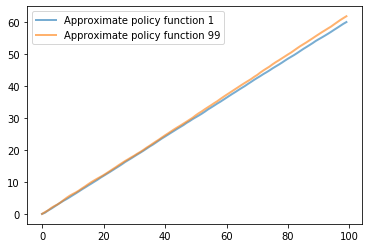

In [60]:
fig, ax = plt.subplots()
ax.plot(v_greedy, lw=2, alpha=0.6,
label='Approximate policy function 1')
ax.plot( v_greedy99, lw=2, alpha=0.6,
label='Approximate policy function 99')
ax.legend()
#ax.set_xlim(40, 60)
plt.show()

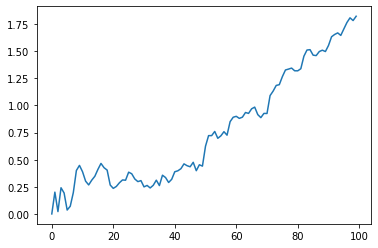

In [61]:
plt.plot(abs(v_greedy - v_greedy99))

In [62]:
def simulate_og(σ_func, og, y0=0.1, ts_length=100):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
    return y

In [63]:
# Let's consider the output 
σ_func = lambda x: interp(og.grid, v_greedy, x)
y = simulate_og(σ_func, og)

σ_func99 = lambda x: interp(og99.grid, v_greedy99, x)
y_99 = simulate_og(σ_func99, og99)

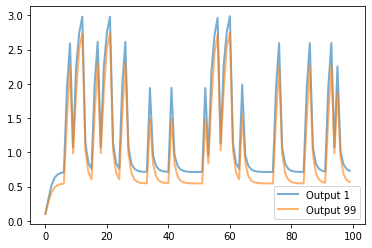

In [64]:
fig, ax = plt.subplots()
ax.plot(y , lw=2, alpha=0.6,
label='Output 1')
ax.plot(y_99, lw=2, alpha=0.6,
label='Output 99')
ax.legend()
#ax.set_xlim(40, 60)
plt.show()

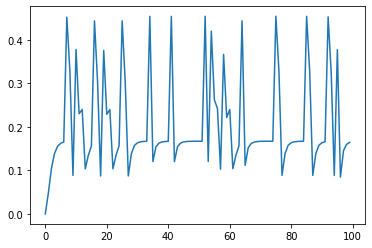

In [65]:
plt.plot(abs(y - y_99))

In [66]:
# Simulate consumption as well
def simulate_og0(σ_func, og, y0=0.1, ts_length=50):
    '''
    Compute a time series given consumption policy σ.
    '''
    c = np.empty(ts_length)
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
        c[t] = σ_func(y[t])
    return y, c

In [67]:
%%time
y_0, c_0 = simulate_og0(σ_func, og, y0=0.1, ts_length=50)

Wall time: 4 ms


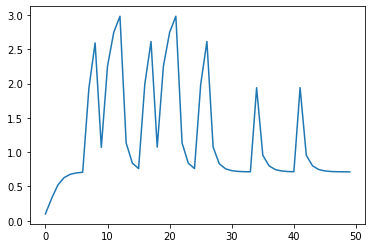

The case with updating 
(so far - the sraightforward way - further - aim to incorporate it in one of the functions)


In [68]:
# estimate v_greedy
def simulate_upd(y0, ts_length, Verbose):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        if ξ[t] == 0 :
            og = OptimalGrowthModel(nuii = nu00[t+1],nuij = nu01[t+1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
        else:
            og = OptimalGrowthModel(nuii = nu11[t+1],nuij = nu10[t+1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
       
    return y

In [123]:
%%time
y_upd = simulate_upd(0.01, 20, Verbose = False)

Wall time: 4min 11s


In [69]:

#%%time
y_u = simulate_upd(0.01, 50, Verbose = False)

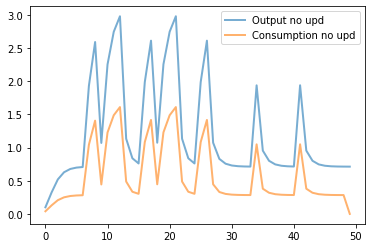

In [70]:
fig, ax = plt.subplots()
ax.plot(y_0 , lw=2, alpha=0.6,
label='Output no upd ')
ax.plot(c_0, lw=2, alpha=0.6,
label='Consumption no upd')
ax.legend()
#ax.set_xlim(40, 60)
plt.show()

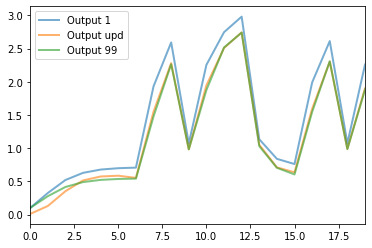

In [101]:
fig, ax = plt.subplots()
ax.plot(y , lw=2, alpha=0.6,
label='Output 1')
ax.plot(y_upd, lw=2, alpha=0.6,
label='Output upd')
ax.plot(y_99 , lw=2, alpha=0.6,
label='Output 99')
ax.legend()
ax.set_xlim(0, 19)
plt.show()


The bellow is the attempt to get speed up code via jit (it's blaming the types of the variables so far... )

In [145]:
@jit (nopython=True)
def upd(t,y, ξ,nuii, nuij):
    og = OptimalGrowthModel(nuii = nuii[t+1],nuij = nuij[t+1])
    v_solution = solve_modelj(og)
    v_greedy = get_greedy(og, v_solution)
    σ_func = lambda x: interp(og.grid, v_greedy, x)
    y_t1 = (y - σ_func(y))**og.α * np.exp(ξ[t])
    return y_t1 


In [152]:

# continue that attempt to use @jit here 
def simulate_updj(y0, X ,ts_length):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    y[0] = y0
    for t in range(ts_length-1):
        if X[t] == 'l' :
            y[t+1] = upd(t, y[t],0 ,  nu00, nu01)
        else:
            y[t+1] = upd(t, y[t],1 ,nu11, nu10)
       
    return y

In [155]:
#%%time
#y_upd = simulate_updj(0.01, X,20)

Actually, need to get simulated consumption as well:


In [37]:
# estimate v_greedy
def simulate_upd_c(y0, ts_length, Verbose):
    '''
    Compute a time series given consumption policy σ.
    '''
    c = np.empty(ts_length)
    y = np.empty(ts_length)
    ξ = ( X == 'h')
    y[0] = y0
    for t in range(ts_length-1):
        if ξ[t] == 0 :
            og = OptimalGrowthModel(nuii = nu00[t+1],nuij = nu01[t+1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
            c[t] = σ_func(y[t])
        else:
            og = OptimalGrowthModel(nuii = nu11[t+1],nuij = nu10[t+1])
            v_solution = solve_model(og,verbose= Verbose)
            v_greedy = get_greedy(og, v_solution)
            σ_func = lambda x: interp(og.grid, v_greedy, x)
            y[t+1] = (y[t] - σ_func(y[t]))**og.α * np.exp(ξ[t])
            c[t] = σ_func(y[t])
       
    return y, c

In [38]:
%%time
y_upp,c_upp = simulate_upd_c(0.01, 50, Verbose = False)

Wall time: 9min 26s


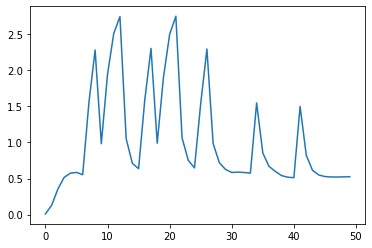

In [163]:
plt.plot(y_upp)

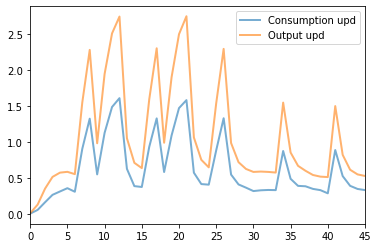

In [73]:
fig, ax = plt.subplots()
ax.plot(c_upp, lw=2, alpha=0.6,
label='Consumption upd')
ax.plot(y_upp , lw=2, alpha=0.6,
label='Output upd ')
ax.legend()
ax.set_xlim(0, 45)
#plt.show()
plt.savefig('plotCYupd.pdf')

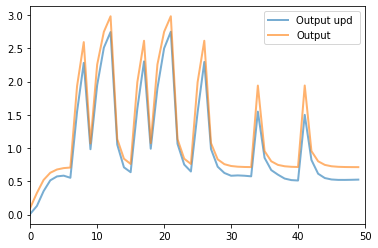

In [184]:
fig, ax = plt.subplots()
ax.plot(y_upp , lw=2, alpha=0.6,
label='Output upd ')
ax.plot(y_0, lw=2, alpha=0.6,
label='Output')
ax.legend()
ax.set_xlim(0, 50)
plt.show()

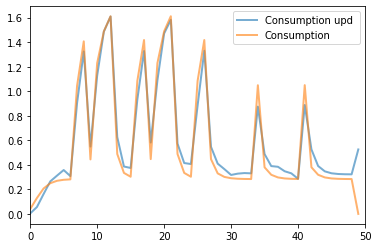

In [187]:
fig, ax = plt.subplots()
ax.plot(c_upp , lw=2, alpha=0.6,
label='Consumption upd ')
ax.plot(c_0, lw=2, alpha=0.6,
label='Consumption')
ax.legend()
ax.set_xlim(0, 50)
plt.show()

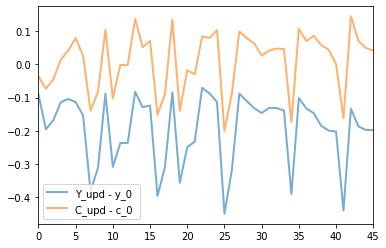

In [74]:
fig, ax = plt.subplots()
ax.plot(y_upp - y_0, lw=2, alpha=0.6,
label='Y_upd - y_0')
ax.plot(c_upp -c_0 , lw=2, alpha=0.6,
label='C_upd - c_0 ')
ax.legend()
ax.set_xlim(0, 45)
#plt.show()
plt.savefig('plotdiff.pdf')

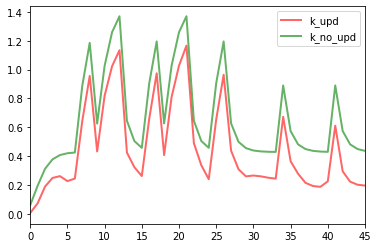

In [197]:
fig, ax = plt.subplots()
ax.plot(y_upp - c_upp,  color='r', lw=2,alpha=0.6, label='k_upd')
ax.plot(y_0 - c_0, color = 'g', lw=2,alpha=0.6, label='k_no_upd')
ax.legend()
ax.set_xlim(0, 45)
plt.savefig('plot_k.pdf')

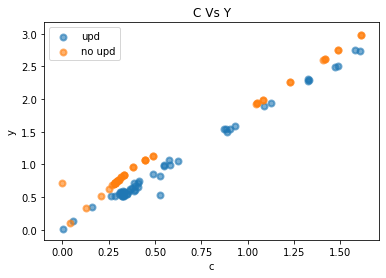

In [199]:
fig, ax = plt.subplots()
ax.scatter(c_upp, y_upp,lw=2,alpha=0.6, label='upd')
ax.scatter(c_0, y_0,lw=2,alpha=0.6, label='no upd')
plt.xlabel('c')
plt.ylabel('y')
plt.title('C Vs Y')
ax.legend()

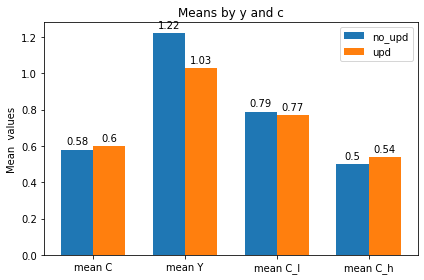

In [212]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
y_one = y_0
c_one = c_0
y_all = y_upp
c_all = c_upp

labels = ['mean C', 'mean Y', 'mean C_l','mean C_h']
means_one = [round(np.mean(c_one),2), round(np.mean(y_one),2),round(np.mean(c_one[X[0:50]=='h']),2), round(np.mean(c_one[X[0:50]=='l']),2)]
means_all = [round(np.mean(c_all),2), round(np.mean(y_all),2),round(np.mean(c_all[X[0:50]=='h']),2), round(np.mean(c_all[X[0:50]=='l']),2)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_one, width, label='no_upd')
rects2 = ax.bar(x + width/2, means_all, width, label='upd')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean  values')
ax.set_title('Means by y and c')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.savefig('means.pdf')

In [208]:
np.mean(c_one[X[0:50]=='h'])


0.7852896869571951

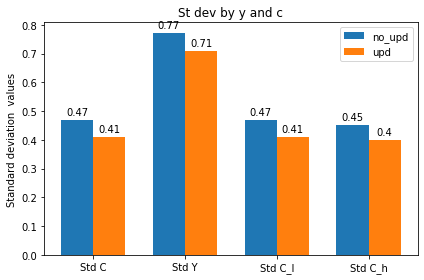

In [214]:
labels = ['Std C', 'Std Y', 'Std C_l','Std C_h']
means_one = [round(np.std(c_one),2), round(np.std(y),2),round(np.std(c_one[X[0:50]=='h']),2), round(np.std(c_one[X[0:50]=='l']),2)]
means_all = [round(np.std(c_all),2), round(np.std(y_all),2),round(np.std(c_all[X[0:50]=='h']),2), round(np.std(c_all[X[0:50]=='l']),2)]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, means_one, width, label='no_upd')
rects2 = ax.bar(x + width/2, means_all, width, label='upd')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Standard deviation  values')
ax.set_title('St dev by y and c')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig('stdev.pdf')

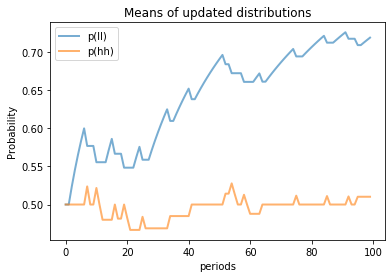

In [222]:
def calculatePupdated2(nii, nij):
    p =  np.empty(n, dtype = float)
    for i in range(len(p)):
        p[i] = beta.stats(nii[i],nij[i] , moments='m') 
    return p


p_upd2 = calculatePupdated2(nu00,nu01) 
q_upd2 = calculatePupdated2(nu01,nu11)



fig, ax = plt.subplots()
ax.plot(p_upd2, lw=2,alpha=0.6, label='p(ll)') 
label='Consumption upd '
ax.plot(q_upd2 ,lw=2,alpha=0.6, label='p(hh)')
ax.set_ylabel('Probability')
ax.set_xlabel('periods')
plt.title('Means of updated distributions')
#ax.set_xlim(0, 45)
ax.legend()

plt.savefig('plot0.pdf')